In [2]:
import psycopg2 as pg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from sklearn.decomposition import PCA, SparsePCA
from summary_stats import SummaryStats
from reducedimensions import DRPC
%matplotlib inline

In [3]:
# Connect to psql database
conn = pg2.connect(dbname='lastfm', user='evansadler', host='/tmp')
c = conn.cursor()

In [4]:
# Get random sample
query = 'SELECT * FROM sample;'
df_t = pd.read_sql_query(query, conn)

In [5]:
# create pivoted dataframe
df_piv = df_t.groupby(['userid','artist'])['plays'].mean().reset_index().pivot(index = 'userid', columns = 'artist', values = 'plays')

In [84]:
df_ss = SummaryStats(df_piv, kurtosis = True, skew = True)
df_ss.head()

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
2pac,26,215.423077,209.803941,1,69.00,143.0,312.75,690,1.667256,3.491546
311,25,188.160000,120.111989,28,112.00,157.0,259.00,547,1.713316,3.504747
3oh!3,22,161.818182,136.158394,24,58.25,112.0,272.50,474,1.473695,2.295857
a perfect circle,28,227.250000,236.105693,2,58.75,156.5,305.50,957,2.151107,5.647449
a tribe called quest,30,200.900000,147.774607,15,107.50,158.0,263.25,591,1.745136,3.757665


In [ ]:
df_ss.ix[df_ss['max'] < 2000, :].hist('min', bins = 100)
plt.show()
df_ss.describe()

In [85]:
pca = SparsePCA(n_components=3, alpha = 5)
clf = DRPC(cluster_model=False, model = pca)

In [86]:
clf.fit(df_ss.fillna(0).values, names = list(df_ss.columns))
clf.components()

,1,2,3
count,0.000000,0.000000,8.262571
mean,-11.321847,0.000000,0.000000
std,-7.793201,1.704623,0.000000
min,0.000000,0.000000,-8.289092
25%,-3.956803,0.000000,0.000000
50%,-8.593795,0.000000,0.000000
75%,-9.837802,0.000000,0.000000
max,-5.631119,7.112596,0.000000
skew,0.000000,11.203467,0.000000
kurtosis,0.000000,11.243395,0.000000


For n_clusters = 2 The average silhouette_score is : 0.259822888791


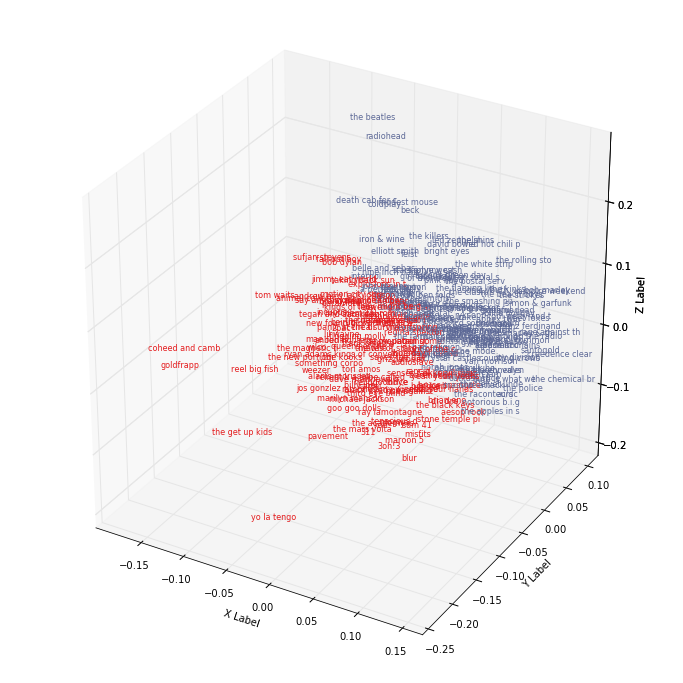

In [88]:
clf.plot_embedding(3, col_names=list(df_ss.index), cluster_list = [2])

In [29]:
df_ss.ix[df_ss.index.str.match('destinys child'),:]

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
destinys child,4,1483,2913.430509,3,13.5,38,1507.5,5853,1.61278,3.030904


In [80]:
df_ss = SummaryStats(df_piv, kurtosis = True, skew = True, axis = 0)
pca = SparsePCA(n_components=3, alpha = 1)
clf = DRPC(cluster_model=False, model = pca)
clf.fit(df_ss.fillna(0).values, names = list(df_ss.columns))
clf.components()

,1,2,3
count,0.000000,0.000000,21.904248
mean,19.953068,4.229241,0.000000
std,21.571294,-7.870025,-1.614934
min,15.640987,8.849767,0.000000
25%,16.554944,8.418518,0.000000
50%,17.631318,7.461112,0.000000
75%,19.218849,4.813025,0.000000
max,22.411699,-6.274678,0.000000
skew,0.000000,-21.378793,0.169757
kurtosis,0.000000,-21.021531,0.213797


For n_clusters = 2 The average silhouette_score is : 0.305133973123


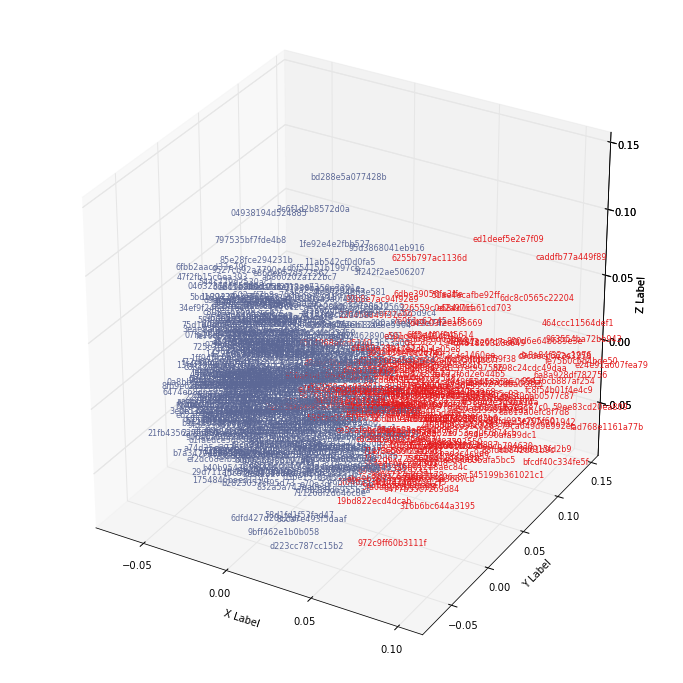

In [82]:
clf.plot_embedding(3, col_names=list(df_ss.index), cluster_list = [2])

In [79]:
#df_piv = df_piv.T.dropna(thresh= 20).T
df_piv = df_piv[df_piv < 1000].dropna(thresh = 20, axis = 0).dropna(thresh=20, axis = 1)

In [149]:
pca = SparsePCA(n_components=8, alpha = 3)
clf = DRPC(cluster_model=False, model = pca)
clf.fit(df_piv.fillna(0).values, names = list(df_piv.columns))

DRPC(cluster_model=False,
   model=SparsePCA(U_init=None, V_init=None, alpha=3, max_iter=1000, method='lars',
     n_components=8, n_jobs=1, random_state=None, ridge_alpha=0.01,
     tol=1e-08, verbose=False),
   scaler=StandardScaler(copy=True, with_mean=True, with_std=True),
   thresh=0.5)

For n_clusters = 3 The average silhouette_score is : 0.335820968059


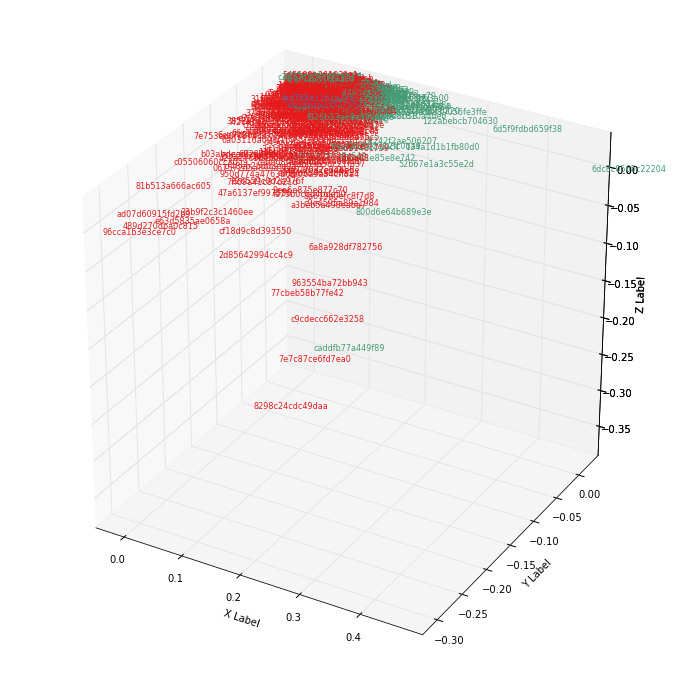

In [155]:
clf.plot_embedding(3, col_names=list(df_piv.index), cluster_list = [3])

In [150]:
df_cp = clf.components()

In [153]:
df_cp.sort(2, ascending= True)

,1,2,3,4,5,6,7,8
paramore,0.000000,-11.950982,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
motion city soundtrack,0.000000,-11.658178,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fall out boy,0.000000,-11.306556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
say anything,0.000000,-10.632316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cartel,0.000000,-9.998468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
the academy is...,0.000000,-9.582837,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
taking back sunday,0.000000,-9.545469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
anberlin,0.000000,-9.396046,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
brand new,0.000000,-8.612595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
thrice,0.000000,-8.333813,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [154]:
df_cp.corr()

,1,2,3,4,5,6,7,8
1,1.000000,0.150054,0.128763,0.091698,0.102878,0.054669,-0.114162,0.109743
2,0.150054,1.000000,-0.023251,-0.111572,-0.081004,-0.102528,0.087932,-0.095630
3,0.128763,-0.023251,1.000000,-0.118086,-0.085733,-0.108513,0.058422,-0.062015
4,0.091698,-0.111572,-0.118086,1.000000,-0.076495,-0.077046,0.079992,-0.040468
5,0.102878,-0.081004,-0.085733,-0.076495,1.000000,-0.065769,0.041016,-0.059901
6,0.054669,-0.102528,-0.108513,-0.077046,-0.065769,1.000000,0.072895,-0.029232
7,-0.114162,0.087932,0.058422,0.079992,0.041016,0.072895,1.000000,0.072565
8,0.109743,-0.095630,-0.062015,-0.040468,-0.059901,-0.029232,0.072565,1.000000
